# Part 1

In [39]:
import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline
import seaborn as sb
sb.set()

In [2]:
## We want to calculate teh average salary
n_people = 100 # The number of people participating
max_salary = 10 # maximum salary of people - otherwise we can't use Laplace
epsilon = 0.1 # the amount of privacy we want to lose

In [3]:
# Assume the distribution of people is coming from a clipped gamma distribution. 
# Not necessarily true
data = np.random.gamma(shape=2, scale=1, size=n_people)
for i in range(n_people):
    data[i] = min(data[i], max_salary)

In [4]:
# Calculate the average salary
average_salary = np.average(data)
print("The actual average salary is ", average_salary)

The actual average salary is  2.0149063122346234


In [5]:
#### Laplace mechanism for local DP
#
# We need the sensitivity of individual data points. Since an
# individual's data can vary at most by max_salary, we have:
local_sensitivity = max_salary
# We now tune the noise to the sensitivity
local_noise = np.random.laplace(scale=local_sensitivity/epsilon, size=n_people)
# Calculate the average
local_average = np.average(data + local_noise)
print("The average salary computed with local DP + Laplace is ", local_average)

The average salary computed with local DP + Laplace is  0.773124387644594


In [6]:
#### Laplace mechanism for centralised DP
#
# We calculate the average, so if an individual's data changes by max_salary, the average
# changes by max_salary / n. So:
central_sensitivity = max_salary / n_people
# We now tune sensitivity to the function
central_noise = np.random.laplace(scale=central_sensitivity / epsilon, size=1)
# Calculate the average
central_average = np.average(data + central_noise)
print("The average salary computed with central DP + Laplace is ", central_average)

The average salary computed with central DP + Laplace is  4.286879354726363


Laplace in local privacy model gives total variance $2\frac{M^2}{\epsilon^2n}$ and in centralised privacy model $2\big(\frac{M}{\epsilon n}\big)^2 = \frac{\text{Local variance}}{n}$

In [30]:
def get_local_average(data, epsilon, n_people, max_salary):
    #### Laplace mechanism for local DP
    #
    # We need the sensitivity of individual data points. Since an
    # individual's data can vary at most by max_salary, we have:
    local_sensitivity = max_salary
    # We now tune the noise to the sensitivity
    local_noise = np.random.laplace(scale=local_sensitivity/epsilon, size=n_people)
    # Calculate the average
    return np.average(data + local_noise)

In [29]:
def get_central_average(data, epsilon, n_people, max_salary):
    #### Laplace mechanism for centralised DP
    #
    # We calculate the average, so if an individual's data changes by max_salary, the average
    # changes by max_salary / n. So:
    central_sensitivity = max_salary / n_people
    # We now tune sensitivity to the function
    central_noise = np.random.laplace(scale=central_sensitivity / epsilon, size=1)
    # Calculate the average
    return np.average(data + central_noise)

In [42]:
# Vary number of people
ns = 50
N = np.logspace(0, 4, ns, dtype=np.int)
iterations = 10000
local_variances = np.zeros(ns)
central_variances = np.zeros(ns)
for i in range(ns):
    n = N[i]
    data = np.random.gamma(shape=2, scale=1, size=n)
    for j in range(n):
        data[j] = min(data[j], max_salary)
    local_averages = np.zeros(iterations)
    central_averages = np.zeros(iterations)
    for j in range(iterations):
        local_averages[j] = get_local_average(data, epsilon, n, max_salary)
        central_averages[j] = get_central_average(data, epsilon, n, max_salary)
    local_variances[i] = np.std(local_averages)
    central_variances[i] = np.std(central_averages)

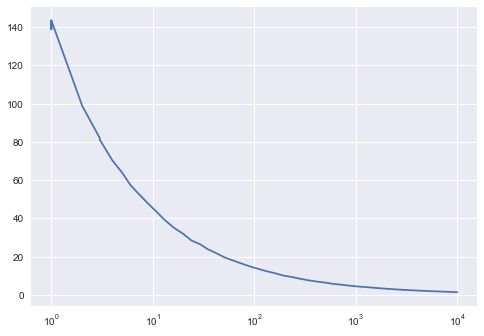

In [43]:
plt.semilogx(N, local_variances)

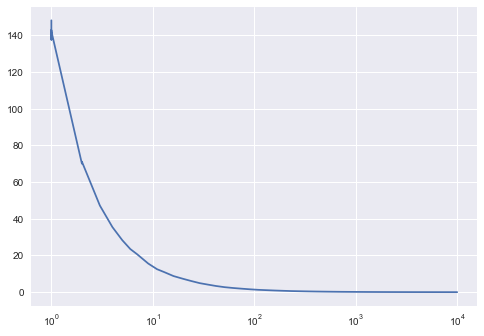

In [44]:
plt.semilogx(N, central_variances)

In [46]:
# Vary epsilon
data = np.random.gamma(shape=2, scale=1, size=n_people)
for i in range(n_people):
    data[i] = min(data[i], max_salary)
es = 50
epsilon = np.logspace(-4, 1, es)
iterations = 10000
local_variances = np.zeros(es)
central_variances = np.zeros(es)
for i in range(es):
    e = epsilon[i]
    local_averages = np.zeros(iterations)
    central_averages = np.zeros(iterations)
    for j in range(iterations):
        local_averages[j] = get_local_average(data, e, n_people, max_salary)
        central_averages[j] = get_central_average(data, e, n_people, max_salary)
    local_variances[i] = np.std(local_averages)
    central_variances[i] = np.std(central_averages)

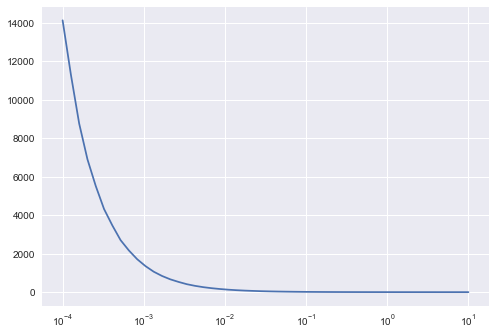

In [47]:
plt.semilogx(epsilon, local_variances)

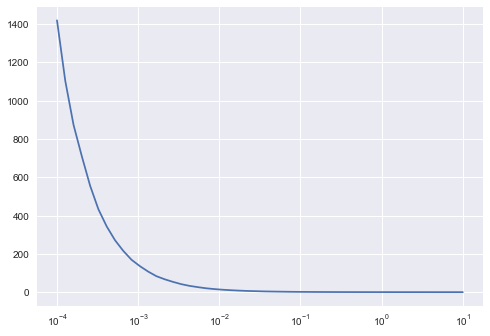

In [48]:
plt.semilogx(epsilon, central_variances)

# Part 2

In [86]:
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import confusion_matrix, accuracy_score, make_scorer
from sklearn.linear_model import LogisticRegression

import numpy as np

From the Notes we have for $p \leq \frac{1}{2}$ we are ($\ln\frac{1-p}{p}$)-DP meaning that for each feature to be $\epsilon$-DP then $\epsilon = \ln\frac{1-p}{p} \implies e^\epsilon = \frac{1-p}{p} \implies p + pe^\epsilon = 1 \implies p = \frac{1}{1+e^\epsilon}$.

Then since each feature should be $\frac{\epsilon}{k}$-DP for a total $\epsilon$-DP, our flip ratio $p$ should be $\frac{1}{1+e^{\frac{\epsilon}{k}}}$.

In [103]:
def create_noisy_data(X, epsilon, k, numerical_features, binary_features):
    flip_fraction = 1 / (1 + np.exp(epsilon/k)) 
    # All non-numerical features are binary. 
    # What fraction should we flip to be epsilon-DP, given that there are k attributes in total? 
    # If we want to be epsilon-DP overall, then each feature should be \epsilon / k - DP.

    X_noise = X.copy()

    n_data = len(X_noise)
    # We can use the same random response mechanism for all binary features
    w = np.random.choice([0, 1], 
                         size=(n_data, len(binary_features)), 
                         p=[1 - flip_fraction, flip_fraction])
    X_noise[binary_features] = (X_noise[binary_features] + w) % 2
    
    # For numerical features, it is different. 
    # The scaling factor should depend on k, \epsilon, and the sensitivity of that particular 
    # attribite. In this case, it's simply the range of the attribute.
    for c in numerical_features:
        lambda_ = (X[c].max()-X[c].min())/(k*epsilon)
        w = np.random.laplace(scale=lambda_, size=n_data)
        X_noise[c] += w

    return X_noise

In [104]:
import pandas
features = ['checking account balance', 'duration', 'credit history',
            'purpose', 'amount', 'savings', 'employment', 'installment',
            'marital status', 'other debtors', 'residence time',
            'property', 'age', 'other installments', 'housing', 'credits',
            'job', 'persons', 'phone', 'foreign']
target = 'repaid'
# Data taken from https://archive.ics.uci.edu/ml/datasets/Statlog+%28German+Credit+Data%29
df = pandas.read_csv('../../data/credit/german.data', sep=' ',
                     names=features+[target])
numerical_features = ['duration', 'age', 'residence time', 'installment', 'amount', 'duration', 'persons', 'credits']
quantitative_features = list(filter(lambda x: x not in numerical_features, features))

X = pandas.get_dummies(df, columns=quantitative_features, drop_first=True)
encoded_features = list(filter(lambda x: x != target, X.columns))

X_noise = create_noisy_data(X, 
                            epsilon=0.1,
                            k=len(encoded_features),
                            numerical_features=numerical_features,
                            binary_features=[f for f in encoded_features if f not in numerical_features])

In [105]:
X_noise.head()

,duration,amount,installment,residence time,age,credits,persons,repaid,checking account balance_A12,checking account balance_A13,...,property_A124,other installments_A142,other installments_A143,housing_A152,housing_A153,job_A172,job_A173,job_A174,phone_A192,foreign_A202
0,-2.791975,-857.286930,2.547130,2.499363,45.089927,1.701282,0.999636,1,0,0,...,1,1,0,0,1,0,0,1,1,0
1,43.025092,414.544350,1.912678,2.113314,14.101350,0.541711,0.615734,2,1,0,...,1,0,1,1,0,0,0,0,1,0
2,61.057727,1333.839702,1.830973,3.775776,61.630417,1.365348,2.010173,1,1,1,...,0,1,0,1,0,0,1,1,0,0
3,47.148963,9421.882222,3.741428,6.389558,50.930502,4.244969,1.953721,1,1,0,...,0,1,1,1,1,0,1,1,1,0
4,41.118625,540.732799,2.920986,3.229260,36.835162,1.218662,1.782928,2,0,1,...,0,0,1,1,1,0,1,1,0,0


In [106]:
cv_accuracy = cross_val_score(LogisticRegression(),
                X[encoded_features],
                X[target],
                scoring=make_scorer(accuracy_score),
                cv=10)
cv_accuracy.mean(), cv_accuracy.std()

(0.749, 0.04011234224026317)

In [107]:
cv_accuracy = cross_val_score(LogisticRegression(),
                X_noise[encoded_features],
                X_noise[target],
                scoring=make_scorer(accuracy_score),
                cv=10)
cv_accuracy.mean(), cv_accuracy.std()

(0.6799999999999999, 0.02190890230020662)

Now test for different values of $\epsilon$ and plot

In [118]:
es = 50
epsilon = np.logspace(-4, 4, es)
binary_features = [f for f in encoded_features if f not in numerical_features]
accuracy_std = np.zeros(es)
accuracy_mean = np.zeros(es)
for i in range(es):
    # Generate new noisy data
    X_noise = create_noisy_data(X, 
                            epsilon=epsilon[i],
                            k=len(encoded_features),
                            numerical_features=numerical_features,
                            binary_features=binary_features)
                
    cv_accuracy = cross_val_score(LogisticRegression(),
                                  X_noise[encoded_features],
                                  X_noise[target],
                                  scoring=make_scorer(accuracy_score),
                                  cv=10)
    accuracy_mean[i] = cv_accuracy.mean()
    accuracy_std[i] = cv_accuracy.std()

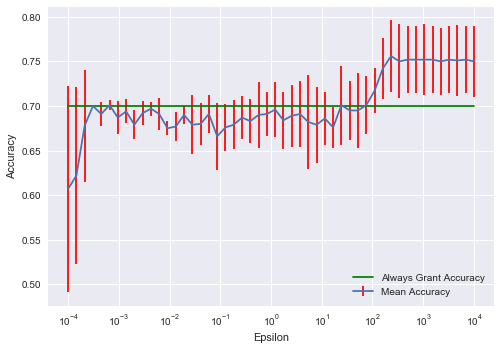

In [122]:
plt.errorbar(epsilon, accuracy_mean, yerr=accuracy_std, ecolor='r', label="Mean Accuracy")
plt.plot(epsilon, [2-X[target].mean() for _ in range(es)], 'g-', label="Always Grant Accuracy")
plt.xscale('log')
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.legend(bbox_to_anchor=(1, 0), loc='lower right')